In [1]:
#!pip install networkx --user
import numpy as np
import networkx as nx
print("Networkx version: {}".format(nx.__version__))
from time import time
import matplotlib.pyplot as plt
import random
import seaborn as sns
sns.set()

print("numpy version: {}".format(np.__version__))
print("Networkx version: {}".format(nx.__version__))

import ddot
from ddot import Ontology
from scipy.stats import norm
import numexpr
numexpr.print_versions()
%matplotlib inline

Networkx version: 1.11
numpy version: 1.19.2
Networkx version: 1.11
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Numexpr version:   2.7.3
NumPy version:     1.19.2
Python version:    3.7.10 (default, Feb 26 2021, 13:06:18) [MSC v.1916 64 bit (AMD64)]
Platform:          win32-AMD64-10.0.19041
CPU vendor:        AuthenticAMD
CPU model:         AMD Ryzen 7 4800H with Radeon Graphics         
CPU clock speed:   2895 MHz
VML available?     True
VML/MKL version:   Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
Number of threads used by default: 8 (out of 16 detected cores)
Maximum number of threads: 64
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


In [2]:
import tensorflow as tf
print(tf.__version__)

import os
#print(os.environ['HOME'])
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

from tensorflow_probability import edward2 as ed
tfd = tfp.distributions

#from numba import cuda 
#device = cuda.get_current_device()
#device.reset()

2.0.0
Using a CPU


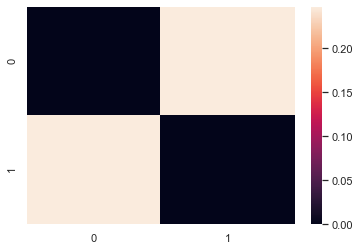

In [3]:
Gorig = nx.read_edgelist("data/new/co-expression.tsv", delimiter='\t' , nodetype=str,  data=(('weight',float),))
for u,v,d in Gorig.edges(data=True):
    Gorig[u][v]['weight']= Gorig[u][v]['weight'] + np.random.normal(0,0.001)
#H = Gorig.subgraph(['ACD', 'ABL1', 'ACTL6A', 'ACTR5', 'ACTR8', 'ALKBH1', 'ALKBH2', 'ALKBH3'])
#mapping = {'ACD':6, 'ABL1':3, 'ACTL6A':7, 'ACTR5':5, 'ACTR8':0, 'ALKBH1':1, 'ALKBH2':2, 'ALKBH3':4}
H = Gorig.subgraph(['ACD', 'ABL1', 'ACTL6A', 'ACTR5', 'ACTR8', 'ALKBH3'])
mapping = {'ACD':6, 'ABL1':3, 'ACTL6A':7, 'ACTR5':5, 'ACTR8':0, 'ALKBH3':4}
G0 = nx.relabel_nodes(H, mapping)
A = nx.adjacency_matrix(G0).todense()
ax = sns.heatmap(A)

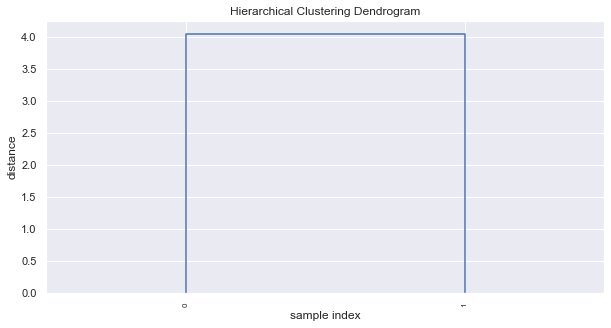

array([[0.        , 1.        , 4.04516123, 2.        ]])

In [4]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform

for u,v,d in G0.edges(data=True):
    G0[u][v]['weight']= 1.0/G0[u][v]['weight']

A = nx.adjacency_matrix(G0).todense()    
listA = squareform(A)
Z = linkage(listA, 'ward')

plt.figure(figsize=(10, 5))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()
Z

In [5]:
import networkx as nx
from networkx import relabel

Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
terms = nx.get_node_attributes(Gnew, 'term')
terms

{0: 'ACD',
 1: 'ADNP',
 2: 'ALKBH2',
 3: 'ALKBH3',
 4: 'APEX1',
 5: 'APEX2',
 6: 'APLF',
 7: 'APTX',
 8: 'ATAD5',
 9: 'ATM',
 10: 'ATR',
 11: 'ATRIP',
 12: 'ATRX',
 13: 'BARD1',
 14: 'BCCIP',
 15: 'BLM',
 16: 'BRAT1',
 17: 'BRCA1',
 18: 'BRCA2',
 19: 'BRCC3',
 20: 'BRE',
 21: 'BRIP1',
 22: 'CBX3',
 23: 'CCNA2',
 24: 'CCNH',
 25: 'CDC7',
 26: 'CDC45',
 27: 'CDK2',
 28: 'CDK7',
 29: 'CENPK',
 30: 'CEP152',
 31: 'CETN2',
 32: 'CETN3',
 33: 'CHAF1A',
 34: 'CHEK1',
 35: 'CHEK2',
 36: 'CHTF18',
 37: 'CKS2',
 38: 'CLK2',
 39: 'CLSPN',
 40: 'DBF4B',
 41: 'DCLRE1A',
 42: 'DCLRE1B',
 43: 'DCLRE1C',
 44: 'DDB1',
 45: 'DDB2',
 46: 'DHX9',
 47: 'DMC1',
 48: 'DNA2',
 49: 'DRG1',
 50: 'DSCC1',
 51: 'DTL',
 52: 'DUT',
 53: 'EME1',
 54: 'EME2',
 55: 'ENDOV',
 56: 'ERCC1',
 57: 'ERCC2',
 58: 'ERCC3',
 59: 'ERCC4',
 60: 'ERCC5',
 61: 'ERCC6',
 62: 'ERCC8',
 63: 'EXO1',
 64: 'FAAP20',
 65: 'FAAP24',
 66: 'FAAP100',
 67: 'FAM175A',
 68: 'FAN1',
 69: 'FANCA',
 70: 'FANCB',
 71: 'FANCC',
 72: 'FANCD2',
 73: 

In [9]:
#tf.stack([np.asarray(nx.to_numpy_matrix(Gnew))]*400)
b0

NameError: name 'b0' is not defined

In [6]:
import pandas as pd
print("pandas version: {}".format(pd.__version__))
#!!!! get a sub-branch of OG so that Gref becomes a subset of 306 genes
ont0 = pd.read_csv('data/pearl2015.txt', sep='\t', header=None)
ont = Ontology.from_table(ont0)
print(ont)
#df.to_csv('pdTest.csv')
Gref0 = ont.to_networkx()
genes = [u for u,v,e in Gref0.edges(data=True) if e[2] == 'Gene-Term']
genes = list(set(genes))
len(genes)

pandas version: 0.23.4
437 genes, 74 terms, 533 gene-term relations, 74 term-term relations
node_attributes: []
edge_attributes: [2]


437

In [7]:
match = []
for gene in genes:
    if gene in terms.values():
        match.append(gene)
len(match)

231

In [8]:
for node in Gref0.nodes():
    if len(Gref0.in_edges(node, data=True)) == 0: #terminal nodes
        Gref0.node[node]['level'] = 0
    else: Gref0.node[node]['level'] = -1
for parent in Gref0.successors('G2-M checkpoint'):
    print(parent)

Checkpoint factors


In [9]:
def get_level(level):
    for child in Gref0.nodes():
        if Gref0.node[child]['level'] == level: #get all nodes at level
            newLevel = level
            #print(child)
            for parent in Gref0.successors(child): #get parents one level above
                newLevel = level+1
                #print(parent)
                if newLevel > Gref0.node[parent]['level']: #check if the parent's level needs to be raised
                    Gref0.node[parent]['level'] = newLevel
                if child in match:
                    if parent not in match:
                        match.append(parent)
    return newLevel

for node in Gref0.nodes():
    if len(Gref0.in_edges(node, data=True)) == 0: #terminal nodes
        Gref0.node[node]['level'] = 0
    else: Gref0.node[node]['level'] = -1
level = 0
newLevel = 0
while  newLevel == level:
    newLevel = get_level(level)
    level += 1
    print(newLevel)
        
sorted(Gref0.nodes(data=True), key=lambda t: t[1].get('level', 1), reverse = True)

1
2
3
4
5
5


[('Repair pathway',
  {'NodeType': 'Term',
   'Size': 360,
   'isRoot': False,
   'Label': 'Repair pathway',
   'x_pos': 245.6241375729524,
   'y_pos': -123.4488005852734,
   'level': 5}),
 ('Associated process',
  {'NodeType': 'Term',
   'Size': 180,
   'isRoot': False,
   'Label': 'Associated process',
   'x_pos': 361.3382902011194,
   'y_pos': 384.6254287489511,
   'level': 4}),
 ('SSR',
  {'NodeType': 'Term',
   'Size': 114,
   'isRoot': False,
   'Label': 'SSR',
   'x_pos': 413.4151021365755,
   'y_pos': -491.5221691238521,
   'level': 3}),
 ('Telomere maintenance',
  {'NodeType': 'Term',
   'Size': 28,
   'isRoot': False,
   'Label': 'Telomere maintenance',
   'x_pos': 299.1150200444178,
   'y_pos': 654.2010548044404,
   'level': 3}),
 ('Ubiquitin response',
  {'NodeType': 'Term',
   'Size': 28,
   'isRoot': False,
   'Label': 'Ubiquitin response',
   'x_pos': 65.48671119842157,
   'y_pos': 293.88603403880245,
   'level': 3}),
 ('Alternative mechanism',
  {'NodeType': 'Term',
   

In [10]:
Gref = Gref0.subgraph(match)
genes = [u for u,v,e in Gref.edges(data=True) if e[2] == 'Gene-Term']
genes = list(set(genes))
len(genes)

231

In [11]:
#nx.write_graphml(Gref, "test.graphml")
Gorig2 = Gorig.subgraph(match)
len(Gorig2)

231

In [12]:
#Define the joint_log_prob function, and our unnormalized posterior.
def SBM_log_prob(z, B, b0, directed=False, selfloops=False):
  # the SBM log-likelihood generative steps
    n = z.shape[0]
    #k = int(n/2)
    #pi = ed.Dirichlet(name='pi', concentration=np.ones(k), sample_shape=[n])
    #eta = tfd.Normal(loc=0, scale=0.01).sample([k,k]) #beta prior for simple edges
    #z = tf.reshape(tfd.Sample(tfd.Categorical(probs=pi),1).sample(), [n,])
    #z = tfd.Bernoulli(probs=pi).sample()
    #z0 = tf.cast(z, tf.float32)
    p = tf.matmul(tf.matmul(z,B),tf.transpose(z))
    A = tfd.Normal(loc=p+b0, scale=0.01)
    #    unsupervised tree/DAG shrinking by factors of 2, supervised grouping by suggesting mergers in a similar ratio 
    #    use tfd.MixtureSameFamily to automatically integrate out the z draws. Construct the mixture dist from pair-wise counting of z draws
    #    p = eta[(z.reshape((n, 1)), z.reshape((1, n)))][triu_indices] #replace with equation 5.5 for analytical posterior, including DC?
    #if weighted:
    #    A = ed.Poisson(name = 'A', mu=p, shape=A_obs[0].shape, observed=A_obs) #collect edge/non-edge statistics for the analytical posterior
    #else:
    return A

In [13]:
class VariationalEstep(tf.keras.Model):
#Optimizes pi and z with fixed phi, B, B0, (a, b are ommitted at the moment)

    def __init__(self, k, n, phi, name=None):
        super(VariationalEstep, self).__init__(name=name)
        self.pi = tf.Variable(tfd.Beta(concentration1=1, concentration0=1).sample([k]), name="pi",constraint=lambda x: tf.clip_by_value(x, 0, 1))
        self.phi = tf.Variable(phi, name="phi",constraint=lambda x: tf.clip_by_value(x, 0, 1))
        self.z = tf.Variable(tfd.RelaxedBernoulli(0.000001, probs=self.phi, validate_args=True, allow_nan_stats=False).sample(n), name="z",constraint=lambda x: tf.clip_by_value(x, 0, 1))
        #self.pi = tf.Variable(tfd.Beta(concentration1=1, concentration0=1).sample([k]), name="pi")
        #self.phi = tf.Variable(phi, name="phi")
        #self.z = tf.Variable(tfd.RelaxedBernoulli(0.000001, probs=self.phi, validate_args=True, allow_nan_stats=False).sample(n), name="z")
        #self.b0 = tf.Variable(tf.exp(tf.random.normal([1])), name='b0')
        #self.s_alpha = tf.Variable(tf.exp(tf.random.normal([1])), name='s_alpha')
        #self.s_beta = tf.Variable(tf.exp(tf.random.normal([1])), name='s_beta')
    
    #@property
    #def ppi(self):
    #    """Variational posterior for the Beta distribution"""
    #    return tfd.Beta(concentration1=self.s_alpha, concentration0=self.s_beta)
    
    @property
    def pz(self):
        """Variational posterior for the bias parameter"""
        #ppi2 = tfd.Beta(concentration1=self.s_a, concentration0=self.s_b)
        return tfd.Bernoulli(probs=self.pi)
    
    # for free z and pi learning    
    def call(self, GrefBlkVars, B0, k, n):
        """Predict p(y|x)"""
        #sample = lambda x: x.sample() if sampling else x.mean()
        return SBM_log_prob(self.z, GrefBlkVars, B0)
    
    def KLlosses(self,priorZ,power):
        """Sum of KL divergences between posteriors and priors"""
        prior = tfd.Bernoulli(probs=self.phi)
        # L-2 norm for sparsity + KL #consistency of the continous approximation
        return tf.reduce_sum(tf.pow(self.phi,-1))*10+tf.reduce_sum(tfd.kl_divergence(self.pz, prior))\
        +tf.reduce_sum(tf.abs(self.z-tf.cast(self.pz.sample(self.z.shape[0]), tf.float32)))*power\
        +tf.reduce_sum(tf.abs(self.z-priorZ))#incorporating prior for z
        
    def mUpdate(self, phiNew):
        """Sum of KL divergences between posteriors and priors"""
        self.phi = self.phi.assign(phiNew)

In [14]:
#import tensorflow.keras.backend as kerasB
Gnew = relabel.convert_node_labels_to_integers(H, label_attribute = "term") #initilaization
k = len(Gnew)
label = np.zeros(k)
label[1]=1
#label[2]=2
#label[3]=0
#label[4]=1
#label[5]=1
#label[k-1]=4
knew = int(max(label)+1)

# Prior design will be key here, needs external input
L_RATE = 0.005
batchSize = 20
n = len(Gnew)
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)
Y = tf.cast(tf.stack([np.asarray(nx.to_numpy_matrix(Gnew))]*800), dtype=tf.float32)
data_train = tf.data.Dataset.from_tensor_slices(Y).batch(batchSize).shuffle(500)

#@tf.function
def E_step(y,GrefBlkVars,z):
    with tf.GradientTape() as tape:
        log_prob = tf.reduce_mean(model(GrefBlkVars,0.0,knew,n).log_prob(y))
        kl_loss = model.KLlosses(z,10)/n*100
        elbo_loss = kl_loss - log_prob
    gradients = tape.gradient(elbo_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return model

def M_step(z):
    with tf.GradientTape() as tape:
        #log_prob = tf.reduce_mean(model(GrefBlkVars,2.0,k2,n).log_prob(y))
        phi2 = tf.reduce_sum(z, 0)/n
        model.mUpdate(phi2)
    return GrefBlkVars

In [15]:
label

array([0., 1.])

In [16]:
# Function to compute the log posterior probability
import cProfile 
import itertools as it

phi = np.asarray([0.6,0.3]).astype("float32")
model = VariationalEstep(knew,len(Gnew),phi)
labelOneHot = tf.one_hot(label.astype(int), knew, dtype = "float32")
pz = tf.cast(ed.Bernoulli(probs=labelOneHot, name="z"), dtype=tf.float32)
labelnew = np.where(labelOneHot>0.5,1,0)

totalW = nx.to_numpy_matrix(Gnew).sum()
GrefBlkVars = np.random.normal(loc = totalW/len(Gnew)/(len(Gnew)-1)*2, scale = 1, size = (knew,knew))
for i in range(knew):
    for j in range(knew): 
        if (j==i): # only update diagonal entries for efficiency
            id1, id2 = zip(*it.product(np.where(labelnew[:,i]==1)[0],np.where(labelnew[:,j]==1)[0])) #cartesian product of the i j blocks
            totalW = sum(np.asarray(nx.to_numpy_matrix(Gnew))[id1, id2]) #total edge weights of the block pair
            GrefBlkVars[i,j] = totalW/len(id1) #averaged over possible edges of the block pair, needs upper-trianglize optimization
GrefBlkVars = tf.convert_to_tensor(np.maximum(GrefBlkVars, GrefBlkVars.T), dtype=tf.float32)

historyPi=[]
historyZ=[]
for (y_data) in data_train:
    posterior = E_step(y_data,GrefBlkVars,pz)
    #updates hyper parameters
    pi = posterior.pi.numpy()
    z = posterior.z.numpy()
    M_step(z)
    print(pi)
    historyPi.append(pi)
    historyZ.append(z)

C:\Users\ryxs8\anaconda3\envs\tf-prob\lib\site-packages\ipykernel_launcher.py:8: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  


[0.2555816 0.9912116]
[0.2604692  0.98630756]
[0.2653308 0.9814583]
[0.27017894 0.9766556 ]
[0.27501404 0.97189677]
[0.279835  0.9671812]
[0.2846391 0.962509 ]
[0.28942442 0.9578804 ]
[0.29418817 0.95329595]
[0.29892755 0.9487562 ]
[0.30363983 0.94426167]
[0.30832118 0.93981284]
[0.31296697 0.9354102 ]
[0.3175722 0.9310539]
[0.322134  0.9267436]
[0.32665017 0.92247975]
[0.33111817 0.9182626 ]
[0.33553502 0.91409236]
[0.33989748 0.9099692 ]
[0.34420213 0.9058932 ]
[0.34844708 0.9018645 ]
[0.3526304  0.89788324]
[0.35675058 0.8939491 ]
[0.36080715 0.89006186]
[0.3648002  0.88622135]
[0.36872905 0.8824271 ]
[0.37259233 0.8786787 ]
[0.37639013 0.8749758 ]
[0.38012367 0.87131816]
[0.38379514 0.8677056 ]
[0.38740623 0.8641378 ]
[0.39095792 0.86061484]
[0.3944494 0.8571364]
[0.3978784  0.85370255]
[0.40124133 0.8503128 ]
[0.4045352 0.8469673]
[0.40775743 0.8436662 ]
[0.41090593 0.84040916]
[0.4139789 0.8371958]
[0.41697335 0.8340254 ]


In [17]:
#import pandas as pd
#pd.DataFrame(ppi.numpy())
model.trainable_variables

[<tf.Variable 'pi:0' shape=(2,) dtype=float32, numpy=array([0.41697335, 0.8340254 ], dtype=float32)>,
 <tf.Variable 'z:0' shape=(2, 2) dtype=float32, numpy=
 array([[0.9553217 , 0.15914193],
        [0.00796789, 0.99852604]], dtype=float32)>]

In [18]:
# Merge quasi-cliques with more than 3 overlapping nodes
def merge_cliques(Clist):
    for i in range(0, len(Clist)):
        c1 = Clist[i]
        for j in range(i+1, len(Clist)):
            c2 = Clist[j]
            if (len(c1.intersection(c2))>1): # define quasi-cliques with number of overlapping nodes
                c3 = c1.union(c2)
                Clist.insert(0,c3)
                Clist.remove(c1)
                Clist.remove(c2)
                return merge_cliques(Clist)
    return Clist

In [19]:
import networkx.algorithms.clique as clique
import itertools as it
import random 

def getCandidatesB(G, Gref, terms):
    parentList = []
    childList= []
    nodeIndex = 0
    for source in terms.values():
        if source in Gref.nodes(): #matched leaf nodes (genes for first layer)
            for target in Gref.successors(source):
                tup = (target,Gref.node[target]['level'])
            tup2 = (source,nodeIndex)
            parentList.append(tup)
            childList.append(tup2)
            nodeIndex = nodeIndex + 1
    parentSet = list(set(parentList))
    childSet = list(set(childList))

    merges = []
    for parent in parentSet:
        c = []
        for predecessor in Gref.predecessors(parent[0]): 
            if len(Gref.in_edges(predecessor, data=True)) == 0: #only include leaves
                if predecessor in terms.values():
                    c.append(predecessor)
        merges.append(set(c))
    CliXO = {}    
    nodeSet = sorted(set().union(*merges))
    for x in nodeSet:
        CliXO[x] = []
        for idx, y in enumerate(merges): 
            if (x in y): #only top 2 appearance are considered in Bayesian assignments
                CliXO[x].append(idx)
    k = len(G) #original block number = graph size
    labels = np.arange(k)
    maxLabel = len(merges)
    print(maxLabel)
    print(len(nodeSet))
    knew = k+maxLabel-len(nodeSet) #new block number after mergers
    label1hot = np.zeros([k,knew])
    print(label1hot.shape)
    labelCount = 0
    for idx, row in enumerate(label1hot):
        if idx<len(nodeSet):
            if (childSet[idx][0] in CliXO): #node to be merged according to CliXO
                #print(childSet[idx][0])
                label1hot[childSet[idx][1],CliXO[childSet[idx][0]]] = 1.0
        else:
            label1hot[idx,maxLabel+labelCount] = 1.0
            labelCount = labelCount+1
    if (maxLabel<=3):
        print("Adding CliXO candidates")
        label1hot = getCandidates(G, 500, 50, 5)
    return label1hot

In [20]:
edgesTop=sorted(Gnew.edges(data=True), key=lambda t: t[2].get('weight', 1), reverse=True)
eList = [(x[0],x[1]) for x in edgesTop[:20]]

In [21]:
import networkx.algorithms.clique as clique
import itertools as it

def getCandidates(G, top, maxC, maxP):
    edgesTop=sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1), reverse=True)
    #percent = int(len(edgesTop)/5000) # adjust for layer size
    eList = [(x[0],x[1]) for x in edgesTop[:top]]
    nodeSet = set().union(*eList)
    sub = G.subgraph(nodeSet)
    graphs = [sub.subgraph(c) for c in nx.connected_components(sub)]
    #print(len(graphs))
    max_clique_sets = [clique.find_cliques(s) for s in graphs]
    cliques = []
    for clist in max_clique_sets:
        tmp = []
        for c in clist:
            if ((len(c)>=2) & (len(c)<=maxC)): #control size of cliques
                cohesion = 0
                for idx, x in enumerate(c):
                    for idy, y in enumerate(c):
                        if (idy>idx):
                            cohesion = cohesion + G[x][y]['weight']
                tup = (set(c),cohesion/(len(c)-1)) #higher order cliques prioritized
                tmp.append(tup)
        tmp = sorted(tmp, key=lambda t: t[1], reverse=True) #sort cliques
        cliques += tmp[:5] #keep only top 3 cliques for each component
    
    CliList = sorted(cliques, key=lambda t: t[1], reverse=True)
    #print(CliList)
    cliquesFiltered0 = [x[0] for x in CliList]
    cliquesFiltered = merge_cliques(cliquesFiltered0)

    CliXO = {}    
    nodeSet = sorted(set().union(*cliquesFiltered))
    for x in nodeSet:
        CliXO[x] = []
        for idx, y in enumerate(cliquesFiltered): 
            if (x in y) and len(CliXO[x])<maxP: #only top 2 appearance are considered in Bayesian assignments
                CliXO[x].append(idx)
    k = len(G) #original block number = graph size
    labels = np.arange(k)
    maxLabel = len(cliquesFiltered)
    knew = k+maxLabel-len(nodeSet) #new block number after mergers
    label1hot = np.zeros([k,knew])
    print(label1hot.shape)
    labelCount = 0
    for idx, row in enumerate(label1hot):
        if (idx in CliXO): #node to be merged according to CliXO
            label1hot[idx,CliXO[idx]] = 1.0
        else:
            label1hot[idx,maxLabel+labelCount] = 1.0
            labelCount = labelCount+1
    return label1hot

In [22]:
def buildLayer(GnewL, Gref, labelOneHot):
    batchSize = 20
    Y = tf.cast(tf.stack([nx.to_numpy_matrix(GnewL)]*400), dtype=tf.float32)
    data_train = tf.data.Dataset.from_tensor_slices(Y).batch(batchSize).shuffle(5000)
    n = len(GnewL)
    
    Mlist = []
    knew = labelOneHot.shape[1]
    ppz = ed.Bernoulli(probs=labelOneHot, name="z").numpy().astype("float32")
    phi = tf.reduce_sum(ppz, 0)/n
    # set initial state (drawn from prior built from OG subgraphs)
    # Prior strength tuning parameter
    # Prior design will be key here, needs external input from corresponding OG layer
    modelInner = VariationalEstep(knew,n,phi)
    totalW = sum(sum(nx.to_numpy_matrix(Gref)))
    GrefBlkVars = np.random.normal(loc = totalW/len(Gref)/(len(Gref)-1)*2, scale = 1, size = (knew,knew))
    labelnew = np.where(labelOneHot>0.5,1,0)
    for i in range(knew):
        if len(np.where(labelnew[:,i]==1)[0])>0:
            for j in range(knew): 
                if (j==i) & len(np.where(labelnew[:,j]==1)[0])>0 : # only update diagonal entries for efficiency
                    id1, id2 = zip(*it.product(np.where(labelnew[:,i]==1)[0],np.where(labelnew[:,j]==1)[0])) #cartesian product of the i j blocks
                    totalW = sum(nx.to_numpy_matrix(Gref)[id1, id2]) #total edge weights of the block pair
                    GrefBlkVars[i,j] = totalW/len(id1) #averaged over possible edges of the block pair, needs upper-trianglize optimization
    GrefBlkVars = tf.convert_to_tensor(np.maximum(GrefBlkVars, GrefBlkVars.T), dtype=tf.float32)

    for (y_data) in data_train:
        with tf.GradientTape() as tape:
            log_prob = tf.reduce_mean(modelInner(GrefBlkVars,0.0,knew,n).log_prob(y_data))
            kl_loss = modelInner.KLlosses(ppz)/n*100
            elbo_loss = kl_loss - log_prob
        gradients = tape.gradient(elbo_loss, modelInner.trainable_variables)
        optimizer.apply_gradients(zip(gradients, modelInner.trainable_variables))
        phi2 = tf.reduce_sum(modelInner.z, 0)/n
        phi2 = np.where(phi2<0.2,0,phi2) #Adjust for different thresholds
        modelInner.mUpdate(phi2)
    return (log_prob,modelInner) #higher order cliques prioritized

In [23]:
def buildLayerB(GnewL, Gref, labelOneHot, power):
    batchSize = 20
    Y = tf.cast(tf.stack([np.asarray(nx.to_numpy_matrix(GnewL))]*400), dtype=tf.float32)
    data_train = tf.data.Dataset.from_tensor_slices(Y).batch(batchSize).shuffle(5000)
    n = len(GnewL)
    
    Mlist = []
    knew = labelOneHot.shape[1]
    ppz = ed.Bernoulli(probs=labelOneHot, name="z").numpy().astype("float32")
    phi = tf.reduce_sum(ppz, 0)/n
    # set initial state (drawn from prior built from OG subgraphs)
    # Prior strength tuning parameter
    # Prior design will be key here, needs external input from corresponding OG layer
    modelInner = VariationalEstep(knew,n,phi)
    totalW = nx.to_numpy_matrix(GnewL).sum()
    GrefBlkVars = np.random.normal(loc = totalW/len(GnewL)/(len(GnewL)-1)*2, scale = 1, size = (knew,knew))
    labelnew = np.where(labelOneHot>0.5,1,0)
    for i in range(knew):
        if len(np.where(labelnew[:,i]==1)[0])>0:
            for j in range(knew): 
                if (j==i) & len(np.where(labelnew[:,j]==1)[0])>0 : # only update diagonal entries for efficiency
                    id1, id2 = zip(*it.product(np.where(labelnew[:,i]==1)[0],np.where(labelnew[:,j]==1)[0])) #cartesian product of the i j blocks
                    totalW = sum(np.asarray(nx.to_numpy_matrix(Gnew))[id1, id2]) #total edge weights of the block pair
                    GrefBlkVars[i,j] = totalW/len(id1) #averaged over possible edges of the block pair, needs upper-trianglize optimization
    GrefBlkVars = tf.convert_to_tensor(np.maximum(GrefBlkVars, GrefBlkVars.T), dtype=tf.float32)
    
    for (y_data) in data_train:
        with tf.GradientTape() as tape:
            log_prob = tf.reduce_mean(modelInner(GrefBlkVars,0.0,knew,n).log_prob(y_data))
            kl_loss = modelInner.KLlosses(ppz,10)/n*100 #update ppz for Bayesian power
            elbo_loss = kl_loss - log_prob
        gradients = tape.gradient(elbo_loss, modelInner.trainable_variables)
        optimizer.apply_gradients(zip(gradients, modelInner.trainable_variables))
        phi2 = tf.reduce_sum(modelInner.z, 0)/n
        phi2 = np.where(phi2<0.2,0,phi2) #Adjust for different thresholds
        modelInner.mUpdate(phi2) #update phi2 for Bayesian power
    modelInner.z = modelInner.z*(1-power)+ppz*power
    return (log_prob,modelInner)

In [24]:
def updateDAG(G, NodeMerge, terms):
    size = len(NodeMerge);
    nodeSet = sorted(set().union(*NodeMerge))
    A = nx.adjacency_matrix(G).todense()
    while len(NodeMerge)>0:
        nodes = NodeMerge.pop()
        newNodeV = np.sum(A[nodes,:],axis=0)/len(nodes)
        B = np.vstack([A, newNodeV])
        newNodeC = np.sum(B[:,nodes],axis=1)/len(nodes)
        A = np.column_stack([B, newNodeC])
        
    #print(nodeSet)
    A = np.delete(A, nodeSet, axis = 0)
    #print(A.shape)
    A = np.delete(A, nodeSet, axis = 1)
    dt=[('weight',float)]
    A = np.matrix(A,dtype=dt)
    np.fill_diagonal(A, 0)
    Gnew = nx.from_numpy_matrix(A)
    Gnew = relabel.convert_node_labels_to_integers(Gnew,label_attribute = "term") 
    
    for node in nodeSet:
        if node in terms:
            del terms[node]
    return Gnew, {i:v for i,(k,v) in enumerate(terms.items(),0)}

In [25]:
def updateDAGB(G, Gref, NodeMerge, internals, terms):    
    size = len(NodeMerge);
    nodeSet = sorted(set().union(*NodeMerge))
    A = nx.adjacency_matrix(G).todense()
    mapping = []

    while len(NodeMerge)>0:
        nodes = NodeMerge.pop()
        internal = internals.pop()
        newNodeV = np.sum(A[nodes,:],axis=0)/len(nodes)
        B = np.vstack([A, newNodeV])
        newNodeC = np.sum(B[:,nodes],axis=1)/len(nodes)
        A = np.column_stack([B, newNodeC])
        #updating the ref graph if merger is matched perfectly
        parentRefs = []
        #print("mergers: ") 
        for kid in nodes:
            #print(terms[kid])
            if (terms[kid] in Gref):
                parentRefs.append(set([n for n in Gref.successors(terms[kid])]))
        #print("internals: ")
        #print(internal)
        if len(parentRefs)>0:
            parentRefs0 = set(parentRefs[0]).intersection(*parentRefs)
            if len(parentRefs0)>0:
                theParent = parentRefs0.pop()
                kidsTerms = [terms[node] for node in nodes]
                if kidsTerms == [n for n in Gref.predecessors(theParent)]:
                    mapping.append({internal:theParent})
                    Gref = nx.relabel_nodes(Gref, {theParent:internal})
                    for kid in nodes:
                        if (terms[kid] in Gref):
                            Gref.remove_node(terms[kid])

    #print(nodeSet)
    A = np.delete(A, nodeSet, axis = 0)
    #print(A.shape)
    A = np.delete(A, nodeSet, axis = 1)
    dt=[('weight',float)]
    A = np.matrix(A,dtype=dt)
    np.fill_diagonal(A, 0)
    Gnew = nx.from_numpy_matrix(A)
    Gnew = relabel.convert_node_labels_to_integers(Gnew,label_attribute = "term") 

    for node in nodeSet:
        if node in terms:
            del terms[node]
    return Gnew, Gref, mapping, {i:v for i,(k,v) in enumerate(terms.items(),0)}

In [26]:
Gnew = relabel.convert_node_labels_to_integers(Gorig2, label_attribute = "term") #initilaization
terms = nx.get_node_attributes(Gnew, 'term') # initilaizatial dictionary for ddot ontology output
maps = [] # for ddot ontology output
gModel = [] # for generative modeling
subsystem = 0 # for ddot ontology output
loop=0
L_RATE = 0.005
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)
#
Gref = ont.to_networkx()
#Gref = nx.from_pandas_edgelist(df,1,0,[2],nx.DiGraph)
for node in Gref.nodes():
    if len(Gref.in_edges(node, data=True)) == 0: #terminal nodes
        Gref.node[node]['level'] = 0
    else: Gref.node[node]['level'] = -1
level = 0
newLevel = 0
while  newLevel == level:
    newLevel = get_level(level)
    level += 1

In [27]:
k = len(Gnew)
print(k)
label1hot = getCandidatesB(Gnew, Gref, terms) #G, top, maxC, maxP
ModelPosterior = buildLayerB(Gnew, Gref, label1hot, 0.9)

231
43
231
(231, 43)


In [28]:
from collections import Counter
from networkx import relabel
import cProfile 
import itertools as it
import ddot
from ddot import Ontology

def f(thresh,power):
    Gnew = relabel.convert_node_labels_to_integers(Gorig2, label_attribute = "term") #initilaization
    terms = nx.get_node_attributes(Gnew, 'term') # initilaizatial dictionary for ddot ontology output
    maps = [] # for ddot ontology output
    gModel = [] # for generative modeling
    subsystem = 0 # for ddot ontology output
    loop=0
    L_RATE = 0.005
    optimizer = tf.keras.optimizers.Adam(lr=L_RATE)
    #
    Gref = ont.to_networkx()
    #Gref = nx.from_pandas_edgelist(df,1,0,[2],nx.DiGraph)
    for node in Gref.nodes():
        if len(Gref.in_edges(node, data=True)) == 0: #terminal nodes
            Gref.node[node]['level'] = 0
        else: Gref.node[node]['level'] = -1
    level = 0
    newLevel = 0
    while  newLevel == level:
        newLevel = get_level(level)
        level += 1

    print("entering supervised stage")        
    #consistency between ref and bayesian posterior required after Supervised levels    
    while True:
        k = len(Gnew)
        print(k)
        label1hot = getCandidatesB(Gnew, Gref, terms) #G, top, maxC, maxP
        #label1hot0 = getCandidates(Gnew, 500, 50, 5) #G, top, maxC, maxP
        #combine label1hot with label1hot0's additional columns via a Bayesian parameter
        if label1hot.shape[1]<= 1: #catch final top block before merging
            print("root block")
            break 
        ModelPosterior = buildLayerB(Gnew, Gref, label1hot, power)
        print(np.max(ModelPosterior[1].z.numpy())) 
        #newInternal = np.where(np.asarray(ModelPosterior) > thresh)[0] #keep Bayesian candidates above threshold

        NodeMerge = [] #nodes to be merged, nested lists of motifs
        newNode = []
        #for node in Gnew.nodes():
            #gModel.append(str(loop)+"th loop:"+terms[node])

        newLabel = ModelPosterior[1].z.numpy()
        threshold = max(thresh,np.percentile(newLabel, 50))#-0.05*(loop))
        newLabelC = np.where(newLabel>=threshold,1,0) #Adjust for different thresholds
        dup = np.where(np.sum(newLabelC,axis=0)>0)[0] #list only duplicate labels where merges could happen
        newCount = label1hot.shape[0] + len(dup)
        print(threshold)
        for dupL in dup: 
            nodes = np.where(newLabelC[:,dupL]>0)[0] #[0] to strip np.where outer brackets
            #print(nodes)
            #if(all(not set(nodes).issubset(set(x)) for x in NodeMerge)):
            NodeMerge.append(nodes)
            for node in nodes: #update ddot ontology with new merges
                gModel.append((terms[node],"subsystem"+str(subsystem),"zPosterior:", newLabel[node,dupL])) #update ddot ontology
            terms[len(terms)] = "subsystem"+str(subsystem)
            newNode.append(terms[len(terms)-1])
            subsystem += 1
        #gModel.append((str(loop)+"th posterior",newLabel))
        nodeSet = sorted(set().union(*NodeMerge))
        newCount = newCount - len(nodeSet)
        Gnew, Gref, mapping, terms = updateDAGB(Gnew, Gref, NodeMerge, newNode, terms) #update the graph with node mergers/splits  
        maps.append(mapping)
        print(len(terms))
        print("looping")
        loop += 1
        
    hierarchy  = [x for x in gModel if "subsystem" in str(x[0])]
    mapping = [x for x in gModel if "subsystem" not in str(x[0])]
    ontOut = Ontology(hierarchy, mapping)
return maps, ontOut

cProfile.run('f(0.2,0.9)')

entering supervised stage
231
43
231
(231, 43)
0.9893676
0.2
43
looping
43
5
5
(43, 43)
0.9869899
0.2
43
looping
43
0
0
(43, 43)
Adding CliXO candidates
(43, 2)
0.9850888
0.492552287876606
2
looping
2
0
0
(2, 2)
Adding CliXO candidates
(2, 1)
root block
         4828526 function calls (4817673 primitive calls) in 4.826 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(all)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(amax)
        3    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(any)
      243    0.000    0.000    0.005    0.000 <__array_function__ internals>:2(array_equal)
       88    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(atleast_2d)
       18    0.000    0.000    0.000    0.000 <__array_function__ internals>:2(can_cast)
       88    0.000    0.000    0.002    0.0

In [29]:
import subprocess
maps, ont2 = f(0.2,0.9)

args = ("../../alignOntology/calculateFDRs", "toy_ontology2.txt", "pearl2015.txt", "0.01", "criss_cross", "testResultNew", "100", "30", "Gene-Term")
#!!! Filter for FDR <0.2 and optimize for matched FDR/len(Gref)
#args = "bin/bar -c somefile.xml -d text.txt -r aString -f anotherString".split()
popen = subprocess.Popen(args, stdout=subprocess.PIPE)
popen.wait()
output = popen.stdout.read()
print(output)

[]

In [30]:
sorted(gModel, key=lambda t: t[3], reverse=False)

[]

In [30]:
import pickle

with open('DAGdump/hierarchySub.save', 'wb') as fp:
    pickle.dump(gModel, fp)

In [456]:
from collections import Counter
from networkx import relabel
import cProfile 
import itertools as it

def f():
    Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
    terms = nx.get_node_attributes(Gnew, 'term') # initilaizatial dictionary for ddot ontology output
    maps = [] # for ddot ontology output
    gModel = [] # for generative modeling
    subsystem = 0 # for ddot ontology output
    loop=0
    L_RATE = 0.005
    optimizer = tf.keras.optimizers.Adam(lr=L_RATE)
    #
    print("entering un-supervised stage")        
    #consistency between ref and bayesian posterior required after Supervised levels    
    while True:
        k = len(Gnew)
        print(k)
        #label1hot = getCandidatesB(Gnew, Gref, terms) #G, top, maxC, maxP
        label1hot = getCandidates(Gnew, 500, 50, 5) #G, top, maxC, maxP
        #print(label1hot.shape)
        if label1hot.shape[1]<= 1: #catch final top block before merging
            print("root block")
            break 
        ModelPosterior = buildLayer(Gnew, Gnew, label1hot)
        print(ModelPosterior[0]) 
        #newInternal = np.where(np.asarray(ModelPosterior) > thresh)[0] #keep Bayesian candidates above threshold

        NodeMerge = [] #nodes to be merged, nested lists of motifs
        newNode = []
        #for node in Gnew.nodes():
            #gModel.append(str(loop)+"th loop:"+terms[node])

        newLabel = ModelPosterior[1].z.numpy()
        threshold = max(0.2,np.percentile(newLabel, 50))#-0.05*(loop))
        newLabelC = np.where(newLabel>=threshold,1,0) #Adjust for different thresholds
        dup = np.where(np.sum(newLabelC,axis=0)>1)[0] #list only duplicate labels where merges could happen
        newCount = label1hot.shape[0] + len(dup)
        print(threshold)
        print(len(terms))
        for dupL in dup: 
            nodes = np.where(newLabelC[:,dupL]>0)[0] #[0] to strip np.where outer brackets
            #print(nodes)
            #if(all(not set(nodes).issubset(set(x)) for x in NodeMerge)):
            NodeMerge.append(nodes)
            for node in nodes: #update ddot ontology with new merges
                gModel.append((terms[node],"subsystem"+str(subsystem),"zPosterior:", newLabel[node,dupL])) #update ddot ontology
            terms[len(terms)] = "subsystem"+str(subsystem)
            newNode.append(terms[len(terms)-1])
            subsystem += 1
        #gModel.append((str(loop)+"th posterior",newLabel))
        nodeSet = sorted(set().union(*NodeMerge))
        newCount = newCount - len(nodeSet)
        print(len(terms))
        Gnew, terms = updateDAG(Gnew, NodeMerge, terms) #update the graph with node mergers/splits  
        maps.append(mapping)
        loop += 1
#cProfile.run('f()')

entering un-supervised stage
437
tf.Tensor(-60637.59, shape=(), dtype=float32)
0.2
437
529
310
tf.Tensor(-59399.164, shape=(), dtype=float32)
0.2
310
381
207
tf.Tensor(-34557.34, shape=(), dtype=float32)
0.2
207
246
145
tf.Tensor(-66290.945, shape=(), dtype=float32)
0.2
145
194
104
tf.Tensor(-27318.57, shape=(), dtype=float32)
0.2
104
126
74
tf.Tensor(-26224.045, shape=(), dtype=float32)
0.2
74
90
52
tf.Tensor(-7387.33, shape=(), dtype=float32)
0.2
52
59
30
root block


In [147]:
#{i:v for i,(k,v) in enumerate(terms.items(),0)}
sorted(gModel, key=lambda t: t[3], reverse=False)

{0: 'subsystem285'}

In [104]:
import pickle

with open('resultNew/hierarchy-base.save', 'wb') as fp:
    pickle.dump(gModel, fp)

In [151]:
Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
Gref = nx.from_pandas_edgelist(df,1,0,[2],nx.DiGraph)
genes = [u for u,v,e in Gref.edges(data=True) if e[2] == 'Gene-Term']
len(Gnew.nodes())-len(set(genes))
for u in Gref.nodes(data=True):
    [x for x,y in Gnew.nodes(data=True) if y['term']==5]

In [ ]:
Gnew = relabel.convert_node_labels_to_integers(Gorig, label_attribute = "term") #initilaization
Gnew.nodes(data=True)

In [ ]:
k = len(Gnew)
print(k)
labels = np.arange(k)
parentList = []
for source, target in Gref.edges(): #calculate logLikeRatio along edges
    if len(Gref.in_edges(source, data=True)) == 0: #leaf nodes (genes)
        parentList.append(target)
random.shuffle(parentList)
parentSet = set(parentList[:5])      
print(parentSet)

merges = []
for parent in parentSet:
    c = []
    for predecessor in Gref.predecessors(parent): #updat
        #print(predecessor)
        if len(Gref.in_edges(predecessor, data=True)) == 0:
            c.append(predecessor)
    merges.append(set(c))
print(merges)
        
CliXO = {}    
nodeSet = sorted(set().union(*merges))
for x in nodeSet:
    CliXO[x] = []
    for idx, y in enumerate(merges): 
        if (x in y) and len(CliXO[x])<3: #only top 2 appearance are considered in Bayesian assignments
            CliXO[x].append(idx)
combinations = it.product(*(CliXO[Name] for Name in nodeSet))    
Llist = []
for update in combinations:
    #print(update)
    labelsNew = labels.copy()    
    for idx, x in enumerate(update):        
        nodeIDs = [x for x,y in Gnew.nodes(data=True) if y['term']==nodeSet[idx]]
        labelsNew[nodeIDs[0]] = len(labels)+x
    b,c =np.unique(labelsNew, return_inverse=True)
    Llist.append(c)

In [ ]:
with open('resultNew/hierarchyQnew2Merge.save', 'wb') as fp:
    pickle.dump(list(G_new.edges), fp)

In [ ]:
sorted([n for n in G.in_degree()], reverse=True)  # degree sequence
inDegrees = G.in_degree()
for node, iDegree in inDegrees():    # for name, age in dictionary.iteritems():  (for Python 2.x)
    if iDegree == 3:
        print(node)

In [ ]:
for n, nbrs in G.adj.items():
    print(G.nodes.data()[n])
    print(G.in_edges(n, data=True))

In [ ]:
edgesTop